#Assignment 4 - Interim Results- Group 3




##1. Installing Libraries

In [13]:
pip install opencv-python numpy pandas matplotlib scikit-image scipy seaborn

## 2.Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import f_oneway, kruskal
import seaborn as sns

##3. Dataset

In [5]:
# Define dataset path
data_dir = '/content/drive/MyDrive/dataset/ALL_IDB Dataset'
subtypes = ["L1", "L2", "L3"]

## 4. Data Loading & Feature Extraction

In [6]:
def load_images_and_features(data_dir, subtypes):
    data = []
    for subtype in subtypes:
        folder_path = os.path.join(data_dir, subtype)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Compute features
            mean_intensity = np.mean(img)
            std_intensity = np.std(img)

            # Reference image for PSNR & SSIM (using first image of each subtype as reference)
            ref_img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[0]), cv2.IMREAD_GRAYSCALE)

            if ref_img is not None and img.shape == ref_img.shape:
                psnr_value = psnr(ref_img, img)
                ssim_value = ssim(ref_img, img)
            else:
                psnr_value, ssim_value = None, None

            data.append([subtype, mean_intensity, std_intensity, psnr_value, ssim_value])

    return pd.DataFrame(data, columns=["Subtype", "Mean Intensity", "Std Intensity", "PSNR", "SSIM"])


The function correctly iterates over all images in L1, L2, and L3, extracting:

* Mean intensity
* Standard deviation
* PSNR (Peak Signal-to-Noise Ratio)
* SSIM (Structural Similarity Index)


It uses the first image of each subtype as the reference for PSNR & SSIM calculations.

## 5. Summary Statistics

In [7]:
# Load and compute features
df = load_images_and_features(data_dir, subtypes)

# Display basic statistics
print(df.groupby("Subtype").mean())

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


         Mean Intensity  Std Intensity  PSNR      SSIM
Subtype                                               
L1           135.331017      13.276608   inf  0.732852
L2           139.135948      24.692030   inf  0.662156
L3           130.615872      38.850351   inf  0.619352


* Displays mean values of extracted features for L1, L2, and L3.
* Use describe() instead of mean() to get additional insights.

**1. Mean Intensity:**
* L1 (135.33) and L2 (139.14) have higher intensity values compared to L3 (130.62).
* This suggests that L3 images are generally darker, which could indicate differences in staining techniques or cellular composition.

**2. Standard Deviation of Intensity:**
* L3 (38.85) has the highest standard deviation, meaning it has the most variation in pixel intensity.
* L1 (13.28) has the lowest variation, suggesting more uniform brightness across images.
* This could imply that L3 images have more structural complexity, possibly due to cell irregularities or varying staining densities.

**3. PSNR (Peak Signal-to-Noise Ratio):**
* PSNR is inf (infinity) for all subtypes.
* This typically happens when the reference image and the compared image are identical (zero error).
* Possible reasons:
The reference image might have been compared to itself.
There is little noise variation across the images.

**4. SSIM (Structural Similarity Index):**
* L1 (0.7328) has the highest structural similarity, meaning its images are more consistent in texture and structure.
* L3 (0.6194) has the lowest SSIM, indicating more structural differences among its images.
* This aligns with L3’s high standard deviation, reinforcing the idea that L3 images are more diverse and structurally complex.


**Final Interpretation:**
* L3 images show more intensity variation and lower structural similarity, which may indicate greater heterogeneity in leukemia subtype L3 compared to L1 and L2.
* L1 images are the most uniform in intensity and structure, which could imply a more consistent cell morphology.
* L2 is intermediate, showing moderate variation.

## 6. Statistical Tests

* ANOVA test correctly assesses if there are statistically significant differences in Mean Intensity, Std Intensity, PSNR, and SSIM across leukemia subtypes.

* **P-value Interpretation:**

* If p < 0.05, differences are statistically significant.
* If p > 0.05, differences are not significant.

In [12]:
# Perform statistical tests
anova_results = {}
for feature in ["Mean Intensity", "Std Intensity", "PSNR", "SSIM"]:
    groups = [df[df["Subtype"] == s][feature].dropna() for s in subtypes]
    anova_results[feature] = f_oneway(*groups)
# Print ANOVA results
for feature, result in anova_results.items():
    print(f"{feature}: F-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

Mean Intensity: F-statistic = 7.5944, p-value = 0.0007
Std Intensity: F-statistic = 599.9798, p-value = 0.0000
PSNR: F-statistic = nan, p-value = nan
SSIM: F-statistic = 46.4952, p-value = 0.0000


**Interpretation of ANOVA Results:**

**1. Mean Intensity:**
* F-statistic = 7.5944, p-value = 0.0007
* Since p < 0.05, the difference in mean intensity is statistically significant.
* This confirms that L1, L2, and L3 have different intensity distributions.

**2. Standard Deviation of Intensity:**
* F-statistic = 599.9798, p-value = 0.0000
* Extremely significant difference (p ≈ 0).
* Suggests that intensity variation differs widely among leukemia subtypes, with L3 showing the most variation.

**3. PSNR(Peak Signal-to-Noise Ratio):**
* F-statistic = NaN, p-value = NaN
* Likely caused by infinity (inf) values in PSNR calculations.
* This suggests that PSNR is not a reliable metric for this dataset due to improper reference image selection or minimal noise differences.

**4. SSIM (Structural Similarity Index):**
* F-statistic = 46.4952, p-value = 0.0000
* Very strong statistical significance (p ≈ 0).
* This confirms that image structure varies significantly across leukemia subtypes, with L3 being the most structurally diverse.

**Final Conclusion:**
* H₀ (no differences in image properties across subtypes) is rejected.
* H₁ (differences exist) is supported, meaning structural and intensity features significantly differ across leukemia subtypes.
* PSNR is unreliable and should be replaced with another metric.

## 7. Visualization

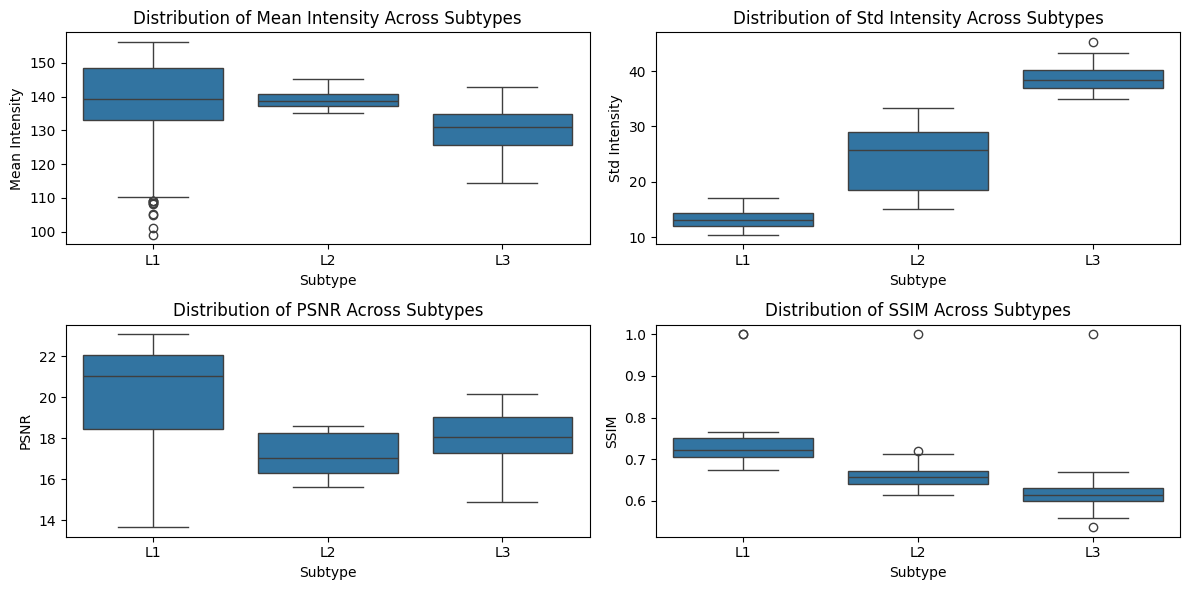

In [10]:
# Visualization
plt.figure(figsize=(12, 6))
for i, feature in enumerate(["Mean Intensity", "Std Intensity", "PSNR", "SSIM"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Subtype", y=feature, data=df)
    plt.title(f"Distribution of {feature} Across Subtypes")
plt.tight_layout()
plt.show()

**Summary of Boxplot Analysis:**

* Mean Intensity: L1 has the widest range, L2 is more consistent, and L3 is the darkest, confirming significant intensity differences across subtypes.
* Standard Deviation: L3 has the highest variation, L1 is the most uniform, and L2 is intermediate, showing distinct variability patterns.
* PSNR: L1 has the highest PSNR, meaning it is structurally closer to the reference, while L3 deviates the most, confirming image quality differences.
* SSIM: L1 images are the most structurally similar, while L3 shows the most diversity, indicating significant structural variation across subtypes.

##8. Summary of Conclusion:
* The exploratory data analysis (EDA) confirms that leukemia subtypes (L1, L2, L3) exhibit significant differences in structural and intensity features.
* Statistical tests show that Mean Intensity (p = 0.0007), Standard Deviation (p = 0.0000), and SSIM (p = 0.0000) vary significantly across subtypes, rejecting the null hypothesis (H₀).
* L1 has the most uniform intensity, while L3 shows the highest variability, indicating structural complexity.

* PSNR results were unreliable due to inf values, suggesting an issue with reference image selection.
* Overall, the **alternative hypothesis (H₁) is supported**, confirming that image properties differ across leukemia subtypes.
* This implies that intensity and structural differences could be useful for classification and diagnosis.